In [1]:
import numpy as np
import pandas as pd
import folium
from folium import plugins
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from statistics import mean

In [9]:
df = pd.read_csv('listings.csv')

In [10]:
# a) Start by producing a Heatmap using the Folium package.

def generateBaseMap(default_location=[40.693943, -73.985880]):
    base_map = folium.Map(location=default_location)
    return base_map

base_map = generateBaseMap()
folium.plugins.HeatMap(data=df[['latitude', 'longitude', 'price']].
        groupby(['latitude', 'longitude']).mean().
        reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map.save('index.html')

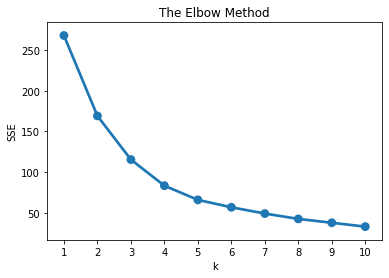

In [11]:
# b) Visualize the clusters by plotting the longitude/latitude of every listing in a scatter plot.

# Fit Kmeans and calculate SSE for each k value
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(df[df.columns[6:8]])
    sse[k] = kmeans.inertia_
    
# plot SSE for each k
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

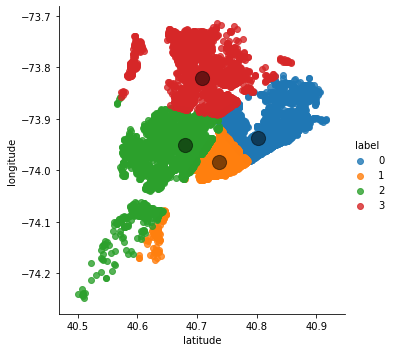

In [12]:
# choose k = 4, visualize 4 clusters
kmeans = KMeans(n_clusters=4, init ='k-means++')
kmeans.fit(df[df.columns[6:8]]) # column 6 & 7 is latitude and longitude
labels = kmeans.predict(df[df.columns[6:8]])
centers = kmeans.cluster_centers_
df['label'] = labels

facet = sns.lmplot(data=df, x='latitude', y='longitude', hue='label', fit_reg=False, legend=True, legend_out=True)
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [13]:
# c) For every cluster report the average price of the listings within this cluster.

# assign each point to its corresponding cluster
clustering = defaultdict(list)
points = np.array(df[df.columns[9]])
for label, point in zip(labels, points):
    clustering[label].append(point)
    
# calculate the average price
averages = []
for idx in sorted(clustering):
    prices = clustering[idx]
    averages.append(mean(prices))
    
averages

[124, 237, 117, 102]

In [18]:
# to see what is the main neighbourhood_group in the most expensive cluster
most_expensive = df['label'] == averages.index(max(averages))
df[most_expensive]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,label
127,32363,Fully Furnished Basement Apartment,140025,Fredah,Queens,Flushing,40.74028,-73.83168,Private room,140,2,1,2011-09-19,0.01,1,63,3
181,51850,( F) Excellent/Pvt Rm,27848,Jullett,Queens,Jamaica,40.67252,-73.76597,Private room,55,2,53,2019-09-03,0.48,4,307,3
184,53469,cozy studio with parking spot,204539,Mark,Queens,Middle Village,40.71722,-73.87856,Entire home/apt,98,7,33,2015-05-09,0.30,5,321,3
186,53477,3 floors of luxury!,204539,Mark,Queens,Middle Village,40.71546,-73.87854,Entire home/apt,265,7,39,2019-08-09,0.37,5,365,3
334,100184,Bienvenue,526653,Ludovic (Dodo),Queens,Queens Village,40.72413,-73.76133,Private room,50,1,46,2019-10-14,0.46,1,82,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50495,40533755,"Maspeth lower level apartment, spacious",313834908,Kathleen,Queens,Maspeth,40.73286,-73.88997,Entire home/apt,120,3,0,NaN,NaN,1,63,3
50530,40541553,"Charming room, close to airports & citifield",256090899,Alicia,Queens,Corona,40.74368,-73.85467,Private room,55,2,0,NaN,NaN,1,179,3
50531,40542672,Cozy bsmt studio with private bathroom near JFK,311879078,Dipu,Queens,Hollis,40.71057,-73.78109,Private room,60,2,0,NaN,NaN,10,345,3
50540,40555735,Beach 28th St 3,2119619,Malcolm/Carolyn,Queens,Far Rockaway,40.59884,-73.76293,Private room,78,1,0,NaN,NaN,3,333,3


In [23]:
# check the main neighbourhood_group within the most expensive cluster
most_expensive = df['label'] == averages.index(max(averages))
df[most_expensive]['neighbourhood_group']

0        Manhattan
2        Manhattan
4        Manhattan
6        Manhattan
7        Manhattan
           ...    
50584    Manhattan
50585    Manhattan
50589    Manhattan
50591    Manhattan
50592    Manhattan
Name: neighbourhood_group, Length: 16790, dtype: object

In [22]:
# check the main neighbourhood_group within the least expensive cluster
least_expensive = df['label'] == averages.index(min(averages))
df[least_expensive]['neighbourhood_group']

127      Queens
181      Queens
184      Queens
186      Queens
334      Queens
          ...  
50495    Queens
50530    Queens
50531    Queens
50540    Queens
50541    Queens
Name: neighbourhood_group, Length: 2999, dtype: object

In [6]:
# m = generateBaseMap()
# for row in df.iterrows():
#     row_values = row[1]
#     latitude = row_values['latitude']
#     longitude = row_values['longitude']
#     location = [latitude, longitude]
#     if row_values['label'] == 0:
#         marker_color = 'lightred'
#     elif row_values['label'] == 1:
#         marker_color = 'cadetblue'
#     elif row_values['label'] == 2:
#         marker_color = 'green'
#     else:
#         marker_color = 'orange'
        
#     marker = folium.Marker(location = location, icon=folium.Icon(color=marker_color))
#     marker.add_to(m)
    
# m.save('index2.html')